In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tueplots import bundles
from tueplots.constants.color import rgb

In [22]:
gain_dict = {}
main_folder_path = '../dat/convergence'
for foldername in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, foldername)

    folder_dict = {}
    print(foldername)

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            key_city = filename.split('_')[1].replace(".json", "")
            key_city = key_city.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')

            df = pd.read_json(file_path, orient='index')
            df.index = df.index.str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue')
            #print(key_city)
            folder_dict[key_city] = df
    
    gain_dict[foldername] = folder_dict
    

#print(dict_avg_gain['Berlin Hbf'])

no_wait
theoretical_max_gain


In [24]:
print(gain_dict["no_wait"])

{'Berlin Hbf':                                                         switch time  \
Dortmund Hbf      [110.0, 94.0, 110.0, 94.0, 46.0, 166.0, 133.0,...   
Duisburg Hbf      [137.0, 137.0, 137.0, 137.0, 46.0, 133.0, 73.0...   
Koeln Hbf         [110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 154...   
Stuttgart Hbf     [74.0, 118.0, 74.0, 118.0, 28.0, 74.0, 118.0, ...   
Mainz Hbf         [170.0, 50.0, 110.0, 50.0, 110.0, 50.0, 110.0,...   
Wiesbaden Hbf     [170.0, 50.0, 170.0, 50.0, 170.0, 50.0, 170.0,...   
Essen Hbf         [137.0, 137.0, 137.0, 137.0, 46.0, 133.0, 73.0...   
Karlsruhe Hbf     [134.0, 58.0, 178.0, 124.0, 134.0, 88.0, 58.0,...   
Saarbruecken Hbf  [64.0, 64.0, 120.0, 64.0, 120.0, 120.0, 64.0, ...   
Duesseldorf Hbf   [137.0, 137.0, 137.0, 137.0, 46.0, 133.0, 73.0...   

                                                               date  \
Dortmund Hbf      [2023-11-25 17:21:00, 2023-11-25 16:43:00, 202...   
Duisburg Hbf      [2023-11-25 17:31:00, 2023-11-27 17:31:00, 

In [26]:
dict_mean_delays = {}


# data processing

# iterate over different gain assumptions
for key_gain, df_dict in gain_dict.items():


    switch_times_array = list(range(1,181,1))
    empty = pd.DataFrame(columns=['switch_times', 'date' ,'mean_delay', 'reachable1', 'reachable2', 'reachable3'])
    empty.switch_times = switch_times_array
    empty['mean_delay'] = [[] for _ in range(180)]
    empty.loc[:, ['reachable1', 'reachable2', 'reachable3']] = 0

    delay_matrix = [[] for _ in range(180)]

    # iterate all dfs in gain assumption
    for key, df in df_dict.items():
        print(key)
        
        #display(df.head(2))
        for irow, row in df.iterrows():
            
            #print(row)

            for i, minute in enumerate(row['switch time']):
                #print(minute)
                if minute > 180:
                    continue
                
        
                delay = row['delay'][i]
                delay_matrix[int(minute-1)].append(delay)

                

                # Fill the reachable columns
                case = row['reachable'][i]
                if case == 1:
                    empty.loc[minute-1, 'reachable1'] += 1
                elif case == 2:
                    empty.loc[minute-1, 'reachable2'] += 1
                elif case == 3:
                    empty.loc[minute-1, 'reachable3'] += 1


    means = []

    for minute in delay_matrix:
        means.append(np.mean(minute).round(2))

    empty['mean_delay'] = means
    df_mean_delays = empty

    dict_mean_delays[key_gain] = df_mean_delays

"""dict_mean_delays = {}

# Assuming gain_dict is defined elsewhere in your code

for key_gain, df_dict in gain_dict.items():
    print(key_gain)
    switch_times_array = np.arange(1, 181)
    delay_matrix = [[] for _ in range(180)]

    # Create DataFrame outside the loop
    df_means = pd.DataFrame({'switch_times': switch_times_array})
    df_means['mean_delay'] = np.nan
    df_means[['reachable1', 'reachable2', 'reachable3']] = 0

    for df in df_dict.values():
        # Flatten the dataframe for vectorized operations
        flat_df = df.explode(['switch time', 'delay', 'reachable'])
        flat_df = flat_df[flat_df['switch time'] <= 180]

        # Group by 'switch time' and calculate means and counts
        grouped = flat_df.groupby('switch time')
        mean_delays = grouped['delay'].mean().apply(lambda x: round(x, 2) if pd.notnull(x) else x)

        reachables = grouped['reachable'].value_counts().unstack().fillna(0)

        # Update the main DataFrame
        df_means.loc[df_means.switch_times.isin(mean_delays.index), 'mean_delay'] = mean_delays.values
        for col in ['reachable1', 'reachable2', 'reachable3']:
            if col in reachables:
                df_means[col] += reachables[col]

    dict_mean_delays[key_gain] = df_means

worst_case = np.array(dict_mean_delays['no_wait']["mean_delay"])
best_case = np.array(dict_mean_delays['theoretical_max_gain']["mean_delay"])"""


Berlin Hbf
Bremen Hbf
Dortmund Hbf
Dresden Hbf
Duesseldorf Hbf
Duisburg Hbf
Erfurt Hbf
Essen Hbf
Hamburg Hbf
Hannover Hbf
Karlsruhe Hbf
Kiel Hbf
Koeln Hbf
Leipzig Hbf
Magdeburg Hbf
Mainz Hbf
Muenchen Hbf
Nuernberg Hbf
Potsdam Hbf
Saarbruecken Hbf
Schwerin Hbf
Stuttgart Hbf
Wiesbaden Hbf
Berlin Hbf
Bremen Hbf
Dortmund Hbf
Dresden Hbf
Duesseldorf Hbf
Duisburg Hbf
Erfurt Hbf
Essen Hbf
Hamburg Hbf
Hannover Hbf
Karlsruhe Hbf
Kiel Hbf
Koeln Hbf
Leipzig Hbf
Magdeburg Hbf
Mainz Hbf
Muenchen Hbf
Nuernberg Hbf
Potsdam Hbf
Saarbruecken Hbf
Schwerin Hbf
Stuttgart Hbf
Wiesbaden Hbf


'dict_mean_delays = {}\n\n# Assuming gain_dict is defined elsewhere in your code\n\nfor key_gain, df_dict in gain_dict.items():\n    print(key_gain)\n    switch_times_array = np.arange(1, 181)\n    delay_matrix = [[] for _ in range(180)]\n\n    # Create DataFrame outside the loop\n    df_means = pd.DataFrame({\'switch_times\': switch_times_array})\n    df_means[\'mean_delay\'] = np.nan\n    df_means[[\'reachable1\', \'reachable2\', \'reachable3\']] = 0\n\n    for df in df_dict.values():\n        # Flatten the dataframe for vectorized operations\n        flat_df = df.explode([\'switch time\', \'delay\', \'reachable\'])\n        flat_df = flat_df[flat_df[\'switch time\'] <= 180]\n\n        # Group by \'switch time\' and calculate means and counts\n        grouped = flat_df.groupby(\'switch time\')\n        mean_delays = grouped[\'delay\'].mean().apply(lambda x: round(x, 2) if pd.notnull(x) else x)\n\n        reachables = grouped[\'reachable\'].value_counts().unstack().fillna(0)\n\n      

C:\Users\jb\AppData\Local\Temp\ipykernel_7764\3371512028.py:27: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * -x) + c
c:\Users\jb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


14.750201465448248
15.71787959561441


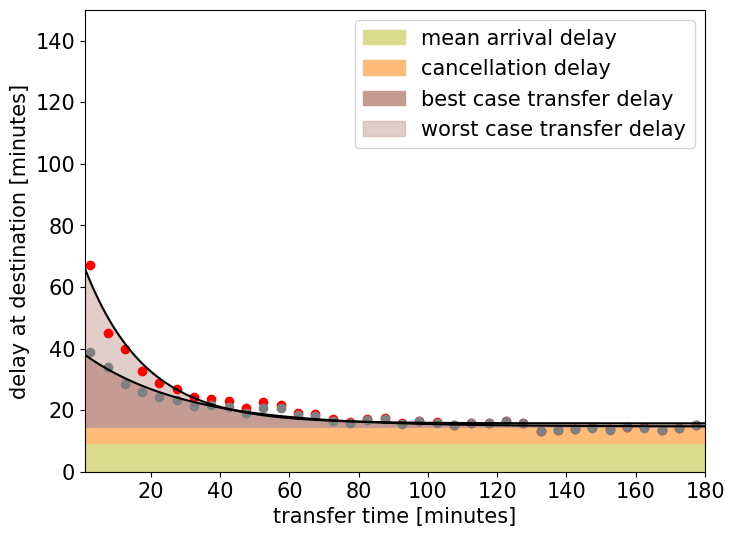

In [52]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

worst_case = np.array(dict_mean_delays['no_wait']["mean_delay"])
best_case = np.array(dict_mean_delays['theoretical_max_gain']["mean_delay"])

if True:
    data_array = np.array(worst_case)
    buckets = data_array.reshape(36, 5)
    means = np.mean(buckets, axis=1)
    worst_case = means

    data_array = np.array(best_case)
    buckets = data_array.reshape(36, 5)
    means = np.mean(buckets, axis=1)
    best_case = means
    x_data = np.arange(2.5, 181, 5)  # Creates an array from 1 to 60
else:
    x_data = np.arange(1, 181)  # Creates an array from 1 to 60

#worst_case = worst_case + x_data
#best_case = best_case + x_data


def exponential_decay(x, a, b, c, d):
    return a * np.exp(b * -x) + c
    #return a * x * x + b * x + c + d * x**3


y_data = best_case  # Replace 'your_function' with your actual function
x = np.arange(1, 181)

params1, covariance1 = curve_fit(exponential_decay, x_data, best_case)
params2, covariance2 = curve_fit(exponential_decay, x_data, worst_case)
print(exponential_decay(180, *params1))
print(exponential_decay(180, *params2))
"""plt.figure(figsize=(8, 6))
plt.scatter(x_data, worst_case, label='Data', color="gray")
plt.scatter(x_data, best_case, label='Data', color="grey")
plt.plot(x, exponential_decay(x, *params1), 'r-', label='Fitted Curve', color="black")
plt.plot(x, exponential_decay(x, *params2), 'r-', label='Fitted Curve', color="black")
plt.axhline(y=9.5, color='blue', linestyle='-')
plt.axhline(y=14.64, color='red', linestyle='-')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Decay Fit')
plt.show()"""

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update()
plt.rcParams.update({'font.size': 15})

import matplotlib.pyplot as plt

# Assuming x_data, worst_case, best_case, x, exponential_decay, params1, and params2 are defined
# If not, you'll need to define them or replace them with your actual data and functions

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the fitted curves

# Horizontal lines


# Fill between areas
ax.fill_between(x, 0, 9.462575828807317, color="#DBDB8D", label='mean arrival delay')
ax.fill_between(x, 9.462575828807317, 14.64, color="#FFBB78", label='cancellation delay')
ax.fill_between(x, 14.64, exponential_decay(x, *params1), color="#C49C94", where=(exponential_decay(x, *params1) >= 14.64), label='best case transfer delay')
ax.fill_between(x, 14.64, exponential_decay(x, *params2), color="#C49C94", alpha=0.5, where=(exponential_decay(x, *params1) >= 14.64), label='worst case transfer delay')


# Scatter plots
ax.scatter(x_data, worst_case, color="red")
ax.scatter(x_data, best_case, color="grey")

ax.plot(x, exponential_decay(x, *params1), color="black")
ax.plot(x, exponential_decay(x, *params2), color="black")


#ax.axhline(y=9.462575828807317, color="#DBDB8D", linestyle='-')
#ax.axhline(y=14.64, color="#FFBB78", linestyle='-')

# Set y and x limits
ax.set_ylim([0, 150])
ax.set_xlim([1, 180])

# Labels and legend
ax.set_xlabel('transfer time [minutes]')
ax.set_ylabel('delay at destination [minutes]')
ax.legend()

# Uncomment the following line if you want to add a title
# ax.set_title('Exponential Decay Fit')

# Show plot
plt.savefig("plot_delay_decomposition.pdf", format="pdf")
plt.show()
